# 서울시 편의점 위치와 매출의 관계 분석
## 르네3's 팀 프로젝트

---

## 📋 프로젝트 개요

| 항목 | 내용 |
|------|------|
| **연구 목적** | 서울시 행정동별 편의점 매출에 영향을 미치는 요인 분석 |
| **분석 기간** | 2022년 1분기 ~ 2025년 3분기 (15개 분기, 약 3.5년) |
| **분석 단위** | 서울시 행정동 × 분기 (패널 데이터) |
| **종속변수** | 행정동별 편의점 분기 추정매출 |
| **독립변수** | 유동인구, 상권유형(5가지), 편의점 점포수(밀집도) |
| **분석 방법** | 다중 회귀분석, VIF, ANOVA |

---

## 📊 데이터 출처 및 기간

**데이터 출처**: 서울시 상권분석서비스 (서울열린데이터광장)

| 데이터 | 파일명 | 수집 기간 | 주요 변수 | 비고 |
|--------|--------|-----------|----------|------|
| 점포 데이터 | stores.csv | 2022Q1~2025Q3 | 점포_수, 프랜차이즈_점포_수, 개업/폐업_점포_수 | 편의점(CS300002) 필터링 |
| 매출 데이터 | sales.csv | 2022Q1~2025Q3 | 당월_매출_금액, 당월_매출_건수 | 추정매출 |
| 유동인구 데이터 | population.csv | 2019Q1~2025Q3 | 총_유동인구_수 | 2022Q1 이후만 사용 |
| 상권영역 데이터 | districts.csv | - | 상권_구분_코드 (A/D/R/U) | 상권유형 매핑 |

---

## 📚 상권유형 분류 체계

| 코드 | 상권유형 | 설명 | 특징 |
|------|----------|------|------|
| A | 골목상권 | 주거지역 내 소규모 상권 | 일반 주거지역, 가장 많음 |
| D | 발달상권 | 대형 상업지역, 역세권 | 강남역, 홍대 등 |
| R | 전통시장 | 전통시장 인근 상권 | 광장시장, 남대문시장 등 |
| U | 관광특구 | 관광객 밀집 지역 | 명동, 이태원, 동대문 등 |
| - | 미분류 | 상권 데이터에 없는 행정동 | 주거 전용 지역 등 |

---

## 📑 분석 구조

```
PART 1: 데이터 준비 및 EDA
├── 1. 환경 설정 및 데이터 로드
├── 2. 데이터 전처리 (인코딩 문제 수정)
├── 3. 데이터 기간 검증 및 정합성 확인
├── 4. 데이터 통합 및 상권유형 매핑
├── 5. 기초 통계량 분석
├── 6. 결측치 분석
├── 7. 이상치 분석 (IQR)
└── 8. 데이터 적합성 판단

PART 2: 탐색적 시각화
├── 9. 변수 분포 히스토그램
├── 10. 연도별/상권유형별 트렌드
├── 11. 상관관계 히트맵
└── 12. 분기별 매출 추이

PART 3: 통계적 심층 분석
├── 13. 더미변수 생성 (5가지 상권유형)
├── 14. VIF 다중공선성 분석
├── 15. 다중 회귀분석 (OLS)
├── 16. 잔차 분석 및 모델 진단
├── 17. ANOVA 분석 (상권유형별 차이 검정)
└── 18. 결과 해석 및 시각화

PART 4: 최종 결론 및 인사이트
├── 19. 핵심 발견사항
├── 20. 전략적 제언
└── 21. 분석의 한계점 및 향후 과제
```

---
# PART 1: 데이터 준비 및 EDA
---

## 1. 환경 설정 및 데이터 로드

In [1]:
# =============================================================================
# 라이브러리 임포트
# =============================================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.stattools import durbin_watson
import statsmodels.api as sm
from scipy import stats
from collections import Counter
import platform
import os

# =============================================================================
# 한글 폰트 설정 (OS별 자동 감지)
# =============================================================================
system = platform.system()
if system == 'Windows':
    plt.rcParams['font.family'] = 'Malgun Gothic'
elif system == 'Darwin':  # Mac
    plt.rcParams['font.family'] = 'AppleGothic'
else:  # Linux
    plt.rcParams['font.family'] = 'NanumGothic'

plt.rcParams['axes.unicode_minus'] = False
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:,.2f}'.format)

print(f"운영체제: {system}")
print(f"Python 버전: {platform.python_version()}")
print(f"Pandas 버전: {pd.__version__}")

운영체제: Windows
Python 버전: 3.13.11
Pandas 버전: 2.2.3


In [2]:
# =============================================================================
# 데이터 경로 설정
# =============================================================================
STORE_PATH = r'../data/processed/stores.csv'
SALES_PATH = r'../data/processed/sales.csv'
POPULATION_PATH = r'../data/processed/population.csv'
DISTRICTS_PATH = r'../data/processed/districts.csv'
OUTPUT_DIR = './outputs'

# 출력 디렉토리 생성
os.makedirs(OUTPUT_DIR, exist_ok=True)

# =============================================================================
# 데이터 로드
# =============================================================================
store_df = pd.read_csv(STORE_PATH, encoding='utf-8-sig')
sales_df = pd.read_csv(SALES_PATH, encoding='utf-8-sig')
pop_df = pd.read_csv(POPULATION_PATH, encoding='utf-8-sig')
area_df = pd.read_csv(DISTRICTS_PATH, encoding='cp949')

print("=" * 70)
print("1. 데이터 로드 완료")
print("=" * 70)
print(f"\n{'데이터':<20} {'행 수':>12} {'열 수':>8}")
print("-" * 45)
print(f"{'점포 데이터':<20} {store_df.shape[0]:>12,} {store_df.shape[1]:>8}")
print(f"{'매출 데이터':<20} {sales_df.shape[0]:>12,} {sales_df.shape[1]:>8}")
print(f"{'유동인구 데이터':<20} {pop_df.shape[0]:>12,} {pop_df.shape[1]:>8}")
print(f"{'상권영역 데이터':<20} {area_df.shape[0]:>12,} {area_df.shape[1]:>8}")

1. 데이터 로드 완료

데이터                           행 수      열 수
---------------------------------------------
점포 데이터                    528,758       12
매출 데이터                    256,378       53
유동인구 데이터                   11,475       25
상권영역 데이터                    1,650       11


## 2. 데이터 전처리 (인코딩 문제 수정)

### ⚠️ 문제 상황
- 원본 CSV 파일의 인코딩 과정에서 **중점(·)**이 **물음표(?)**로 변환됨
- 예시: `종로1·2·3·4가동` → `종로1?2?3?4가동`

### 🔍 영향
- 데이터 병합(merge) 시 `행정동_코드_명`이 일치하지 않아 **결측치 발생**
- 총 2,923개 행에서 물음표 문제 발견

### 🔧 해결 방법
- 모든 데이터프레임에서 `?` → `·` 로 일괄 변환

In [3]:
print("=" * 70)
print("2. 데이터 전처리 (인코딩 문제 수정)")
print("=" * 70)

# =============================================================================
# 수정 전 현황 확인
# =============================================================================
print("\n[수정 전 - '?' 포함 행 수]")
before_counts = {
    '점포 데이터': store_df['행정동_코드_명'].str.contains('\\?', regex=True, na=False).sum(),
    '매출 데이터': sales_df['행정동_코드_명'].str.contains('\\?', regex=True, na=False).sum(),
    '유동인구 데이터': pop_df['행정동_코드_명'].str.contains('\\?', regex=True, na=False).sum(),
    '상권영역 데이터': area_df['행정동_코드_명'].str.contains('\\?', regex=True, na=False).sum()
}

for name, count in before_counts.items():
    print(f"  {name:<18}: {count:>6,}개")

# 예시 출력
print("\n[수정 전 예시]")
problem_examples = pop_df[pop_df['행정동_코드_명'].str.contains('\\?', regex=True, na=False)]['행정동_코드_명'].unique()[:5]
for ex in problem_examples:
    print(f"  {ex}")

2. 데이터 전처리 (인코딩 문제 수정)

[수정 전 - '?' 포함 행 수]
  점포 데이터            :  1,743개
  매출 데이터            :    953개
  유동인구 데이터          :    189개
  상권영역 데이터          :     38개

[수정 전 예시]
  금호2?3가동
  면목3?8동
  중계2?3동
  상계3?4동
  상계6?7동


In [4]:
# =============================================================================
# '?' → '·' 변경 실행
# =============================================================================
store_df['행정동_코드_명'] = store_df['행정동_코드_명'].str.replace('?', '·', regex=False)
sales_df['행정동_코드_명'] = sales_df['행정동_코드_명'].str.replace('?', '·', regex=False)
pop_df['행정동_코드_명'] = pop_df['행정동_코드_명'].str.replace('?', '·', regex=False)
area_df['행정동_코드_명'] = area_df['행정동_코드_명'].str.replace('?', '·', regex=False)

# 수정 후 확인
print("\n[수정 후 - '?' 포함 행 수]")
after_counts = {
    '점포 데이터': store_df['행정동_코드_명'].str.contains('\\?', regex=True, na=False).sum(),
    '매출 데이터': sales_df['행정동_코드_명'].str.contains('\\?', regex=True, na=False).sum(),
    '유동인구 데이터': pop_df['행정동_코드_명'].str.contains('\\?', regex=True, na=False).sum(),
    '상권영역 데이터': area_df['행정동_코드_명'].str.contains('\\?', regex=True, na=False).sum()
}

for name, count in after_counts.items():
    print(f"  {name:<18}: {count:>6,}개")

# 수정 후 예시
print("\n[수정 후 예시]")
fixed_examples = pop_df[pop_df['행정동_코드_명'].str.contains('·', na=False)]['행정동_코드_명'].unique()[:5]
for ex in fixed_examples:
    print(f"  {ex}")

print("\n" + "=" * 70)
print("✓ 인코딩 문제 수정 완료")
print("  모든 '?'가 '·'로 변경되었습니다.")
print("  이제 병합 시 결측치가 대폭 감소할 것입니다.")
print("=" * 70)


[수정 후 - '?' 포함 행 수]
  점포 데이터            :      0개
  매출 데이터            :      0개
  유동인구 데이터          :      0개
  상권영역 데이터          :      0개

[수정 후 예시]
  금호2·3가동
  면목3·8동
  중계2·3동
  상계3·4동
  상계6·7동

✓ 인코딩 문제 수정 완료
  모든 '?'가 '·'로 변경되었습니다.
  이제 병합 시 결측치가 대폭 감소할 것입니다.


## 3. 데이터 기간 검증 및 정합성 확인

In [5]:
print("=" * 70)
print("3. 데이터 기간 검증")
print("=" * 70)
print("\n목표 분석 기간: 2022년 1분기 ~ 2025년 3분기 (15개 분기)")

print("\n" + "-" * 70)
print(f"{'데이터':<18} {'시작':>10} {'종료':>10} {'전체분기':>8} {'분석분기':>8} {'상태':>6}")
print("-" * 70)

for name, df in [('점포 데이터', store_df), ('매출 데이터', sales_df), ('유동인구 데이터', pop_df)]:
    start = df['기준_년분기_코드'].min()
    end = df['기준_년분기_코드'].max()
    total_quarters = df['기준_년분기_코드'].nunique()
    analysis_quarters = df[df['기준_년분기_코드'] >= 20221]['기준_년분기_코드'].nunique()
    status = "✓" if analysis_quarters >= 15 else "⚠"
    print(f"{name:<18} {start:>10} {end:>10} {total_quarters:>8} {analysis_quarters:>8} {status:>6}")

print("-" * 70)
print("\n※ 유동인구 데이터는 2019Q1부터 존재하나, 본 분석에서는 2022Q1 이후만 사용")

3. 데이터 기간 검증

목표 분석 기간: 2022년 1분기 ~ 2025년 3분기 (15개 분기)

----------------------------------------------------------------------
데이터                        시작         종료     전체분기     분석분기     상태
----------------------------------------------------------------------
점포 데이터                  20221      20253       15       15      ✓
매출 데이터                  20221      20253       15       15      ✓
유동인구 데이터                20191      20253       27       15      ✓
----------------------------------------------------------------------

※ 유동인구 데이터는 2019Q1부터 존재하나, 본 분석에서는 2022Q1 이후만 사용


In [6]:
# =============================================================================
# 연도별 데이터 현황 상세
# =============================================================================
print("\n" + "=" * 70)
print("연도별 데이터 건수 현황")
print("=" * 70)

def get_year(quarter_code):
    return quarter_code // 10

print("\n[점포 데이터 - 연도별]")
store_by_year = store_df.groupby(store_df['기준_년분기_코드'].apply(get_year)).size()
for year, count in store_by_year.items():
    print(f"  {year}년: {count:>10,}건")

print("\n[매출 데이터 - 연도별]")
sales_by_year = sales_df.groupby(sales_df['기준_년분기_코드'].apply(get_year)).size()
for year, count in sales_by_year.items():
    print(f"  {year}년: {count:>10,}건")

print("\n[유동인구 데이터 - 연도별 (2022년 이후)]")
pop_filtered_check = pop_df[pop_df['기준_년분기_코드'] >= 20221]
pop_by_year = pop_filtered_check.groupby(pop_filtered_check['기준_년분기_코드'].apply(get_year)).size()
for year, count in pop_by_year.items():
    print(f"  {year}년: {count:>10,}건")


연도별 데이터 건수 현황

[점포 데이터 - 연도별]
  2022년:    140,621건
  2023년:    141,235건
  2024년:    141,001건
  2025년:    105,901건

[매출 데이터 - 연도별]
  2022년:     69,440건
  2023년:     68,643건
  2024년:     67,900건
  2025년:     50,395건

[유동인구 데이터 - 연도별 (2022년 이후)]
  2022년:      1,700건
  2023년:      1,700건
  2024년:      1,700건
  2025년:      1,275건


In [7]:
# =============================================================================
# 데이터 정합성 검증
# =============================================================================
print("\n" + "=" * 70)
print("데이터 정합성 검증 - 행정동 코드 일치 여부")
print("=" * 70)

store_dongs = set(store_df['행정동_코드'].unique())
sales_dongs = set(sales_df['행정동_코드'].unique())
pop_dongs = set(pop_df['행정동_코드'].unique())
area_dongs = set(area_df['행정동_코드'].unique())

print("\n[행정동 코드 현황]")
print(f"  점포 데이터 행정동 수:     {len(store_dongs):>4}개")
print(f"  매출 데이터 행정동 수:     {len(sales_dongs):>4}개")
print(f"  유동인구 데이터 행정동 수: {len(pop_dongs):>4}개")
print(f"  상권영역 데이터 행정동 수: {len(area_dongs):>4}개")

# 공통 행정동
common_dongs = store_dongs & sales_dongs & pop_dongs
print(f"\n[공통 행정동]")
print(f"  점포 ∩ 매출 ∩ 유동인구: {len(common_dongs)}개")

# 누락 확인
sales_not_in_area = sales_dongs - area_dongs
print(f"\n[누락 확인]")
print(f"  매출에는 있지만 상권영역에 없는 행정동: {len(sales_not_in_area)}개")
print(f"  → 이 행정동들은 '미분류' 상권유형으로 처리됩니다.")


데이터 정합성 검증 - 행정동 코드 일치 여부

[행정동 코드 현황]
  점포 데이터 행정동 수:      425개
  매출 데이터 행정동 수:      425개
  유동인구 데이터 행정동 수:  425개
  상권영역 데이터 행정동 수:  399개

[공통 행정동]
  점포 ∩ 매출 ∩ 유동인구: 425개

[누락 확인]
  매출에는 있지만 상권영역에 없는 행정동: 26개
  → 이 행정동들은 '미분류' 상권유형으로 처리됩니다.


## 4. 데이터 통합 및 상권유형 매핑

In [8]:
print("=" * 70)
print("4. 데이터 통합 및 상권유형 매핑")
print("=" * 70)

# =============================================================================
# 편의점 데이터 필터링 (서비스_업종_코드: CS300002)
# =============================================================================
cvs_store = store_df[store_df['서비스_업종_코드'] == 'CS300002'].copy()
cvs_sales = sales_df[sales_df['서비스_업종_코드'] == 'CS300002'].copy()
pop_filtered = pop_df[pop_df['기준_년분기_코드'] >= 20221].copy()

print(f"\n[편의점 데이터 필터링 결과]")
print(f"  점포 데이터: {store_df.shape[0]:>10,}건 → {cvs_store.shape[0]:>10,}건 (편의점만)")
print(f"  매출 데이터: {sales_df.shape[0]:>10,}건 → {cvs_sales.shape[0]:>10,}건 (편의점만)")
print(f"  유동인구:    {pop_df.shape[0]:>10,}건 → {pop_filtered.shape[0]:>10,}건 (2022Q1~)")

4. 데이터 통합 및 상권유형 매핑

[편의점 데이터 필터링 결과]
  점포 데이터:    528,758건 →      6,375건 (편의점만)
  매출 데이터:    256,378건 →      6,097건 (편의점만)
  유동인구:        11,475건 →      6,375건 (2022Q1~)


In [9]:
# =============================================================================
# 상권유형 매핑 (4가지 분류)
# =============================================================================
area_type_map = {
    'A': '골목상권',
    'D': '발달상권',
    'R': '전통시장',
    'U': '관광특구'
}
area_df['상권유형'] = area_df['상권_구분_코드'].map(area_type_map)

# 상권유형별 현황 확인
print("\n[상권유형별 현황 - 원본 상권영역 데이터]")
area_stats = area_df.groupby('상권유형').agg(
    상권수=('상권_코드', 'nunique'),
    행정동수=('행정동_코드', 'nunique')
).reset_index()

print(f"\n{'상권유형':<10} {'상권 수':>10} {'행정동 수':>10}")
print("-" * 35)
for _, row in area_stats.iterrows():
    print(f"{row['상권유형']:<10} {row['상권수']:>10,} {row['행정동수']:>10}")


[상권유형별 현황 - 원본 상권영역 데이터]

상권유형             상권 수      행정동 수
-----------------------------------
골목상권            1,090        381
관광특구                6          6
발달상권              249        155
전통시장              305        217


In [10]:
# =============================================================================
# 행정동별 주요 상권유형 결정
# 규칙: 관광특구 > 발달상권 > 전통시장 > 골목상권 (우선순위)
# =============================================================================
def get_priority_sangwon(sangwon_list):
    """우선순위에 따른 상권유형 결정"""
    priority = ['관광특구', '발달상권', '전통시장', '골목상권']
    for p in priority:
        if p in sangwon_list:
            return p
    return Counter(sangwon_list).most_common(1)[0][0]

area_by_dong = area_df.groupby('행정동_코드')['상권유형'].agg(list).reset_index()
area_by_dong['주요_상권유형'] = area_by_dong['상권유형'].apply(get_priority_sangwon)
area_by_dong = area_by_dong[['행정동_코드', '주요_상권유형']]

# 결과 확인
print("\n[행정동별 주요 상권유형 분포]")
main_type_counts = area_by_dong['주요_상권유형'].value_counts()
for t, c in main_type_counts.items():
    print(f"  {t:10s}: {c:>4}개 행정동")

print("\n※ 상권유형 결정 규칙: 관광특구 > 발달상권 > 전통시장 > 골목상권")
print("   한 행정동에 여러 상권유형이 있으면 우선순위가 높은 것을 선택")


[행정동별 주요 상권유형 분포]
  발달상권      :  149개 행정동
  전통시장      :  140개 행정동
  골목상권      :  104개 행정동
  관광특구      :    6개 행정동

※ 상권유형 결정 규칙: 관광특구 > 발달상권 > 전통시장 > 골목상권
   한 행정동에 여러 상권유형이 있으면 우선순위가 높은 것을 선택


In [11]:
# =============================================================================
# 데이터 집계 (행정동 × 분기)
# =============================================================================
cvs_store_agg = cvs_store.groupby(['기준_년분기_코드', '행정동_코드', '행정동_코드_명']).agg(
    점포_수=('점포_수', 'sum'),
    프랜차이즈_점포_수=('프랜차이즈_점포_수', 'sum'),
    개업_점포_수=('개업_점포_수', 'sum'),
    폐업_점포_수=('폐업_점포_수', 'sum')
).reset_index()

cvs_sales_agg = cvs_sales.groupby(['기준_년분기_코드', '행정동_코드', '행정동_코드_명']).agg(
    당월_매출_금액=('당월_매출_금액', 'sum'),
    당월_매출_건수=('당월_매출_건수', 'sum')
).reset_index()

pop_agg = pop_filtered.groupby(['기준_년분기_코드', '행정동_코드', '행정동_코드_명']).agg(
    총_유동인구_수=('총_유동인구_수', 'sum')
).reset_index()

print("\n[데이터 집계 결과]")
print(f"  점포 집계:    {cvs_store_agg.shape[0]:>6,}건 (행정동 × 분기)")
print(f"  매출 집계:    {cvs_sales_agg.shape[0]:>6,}건 (행정동 × 분기)")
print(f"  유동인구 집계: {pop_agg.shape[0]:>6,}건 (행정동 × 분기)")


[데이터 집계 결과]
  점포 집계:     6,375건 (행정동 × 분기)
  매출 집계:     6,097건 (행정동 × 분기)
  유동인구 집계:  6,375건 (행정동 × 분기)


In [12]:
# =============================================================================
# 데이터 병합
# =============================================================================
merged = cvs_sales_agg.merge(
    cvs_store_agg, 
    on=['기준_년분기_코드', '행정동_코드', '행정동_코드_명'], 
    how='left'
)
merged = merged.merge(
    pop_agg, 
    on=['기준_년분기_코드', '행정동_코드', '행정동_코드_명'], 
    how='left'
)
merged = merged.merge(
    area_by_dong, 
    on='행정동_코드', 
    how='left'
)

# 연도/분기 추출
merged['연도'] = (merged['기준_년분기_코드'] // 10).astype(int)
merged['분기'] = (merged['기준_년분기_코드'] % 10).astype(int)
merged['년분기'] = merged['연도'].astype(str) + 'Q' + merged['분기'].astype(str)

print("\n[데이터 병합 결과]")
print(f"  총 데이터: {merged.shape[0]:,}건 × {merged.shape[1]}컬럼")
print(f"  행정동 수: {merged['행정동_코드'].nunique()}개")
print(f"  분기 수:   {merged['기준_년분기_코드'].nunique()}개")


[데이터 병합 결과]
  총 데이터: 6,097건 × 14컬럼
  행정동 수: 414개
  분기 수:   15개


In [13]:
# =============================================================================
# 상권유형 결측 처리 → '미분류' 범주 생성
# =============================================================================
print("\n" + "=" * 70)
print("상권유형 결측 처리")
print("=" * 70)

missing_cnt = merged['주요_상권유형'].isnull().sum()
missing_ratio = (missing_cnt / len(merged) * 100)

print(f"\n[처리 전]")
print(f"  주요_상권유형 결측: {missing_cnt:,}개 ({missing_ratio:.2f}%)")

if missing_cnt > 0:
    missing_dongs = merged[merged['주요_상권유형'].isnull()]['행정동_코드_명'].unique()
    print(f"  결측 발생 행정동: {len(missing_dongs)}개")
    print(f"  예시: {', '.join(missing_dongs[:5])}")
    print(f"\n  → 원인: 해당 행정동이 공식 상권영역 데이터에 포함되지 않음")
    print(f"  → 대부분 주거 전용 지역으로 추정")

# 미분류로 대체
merged['주요_상권유형'] = merged['주요_상권유형'].fillna('미분류')

print(f"\n[처리 후]")
print(f"  주요_상권유형 결측: {merged['주요_상권유형'].isnull().sum()}개")

# 최종 상권유형 분포
print(f"\n[최종 상권유형 분포]")
type_counts = merged['주요_상권유형'].value_counts()
for area_type, count in type_counts.items():
    ratio = (count / len(merged) * 100)
    print(f"  {area_type:10s}: {count:>5,}개 ({ratio:>5.2f}%)")

print("\n" + "=" * 70)
print("✓ 데이터 통합 완료")
print(f"  최종 분석 데이터: {len(merged):,}건")
print(f"  상권유형: 5가지 (골목상권, 발달상권, 전통시장, 관광특구, 미분류)")
print("=" * 70)


상권유형 결측 처리

[처리 전]
  주요_상권유형 결측: 339개 (5.56%)
  결측 발생 행정동: 24개
  예시: 행당2동, 돈암1동, 월계3동, 하계2동, 중계1동

  → 원인: 해당 행정동이 공식 상권영역 데이터에 포함되지 않음
  → 대부분 주거 전용 지역으로 추정

[처리 후]
  주요_상권유형 결측: 0개

[최종 상권유형 분포]
  발달상권      : 2,227개 (36.53%)
  전통시장      : 2,006개 (32.90%)
  골목상권      : 1,435개 (23.54%)
  미분류       :   339개 ( 5.56%)
  관광특구      :    90개 ( 1.48%)

✓ 데이터 통합 완료
  최종 분석 데이터: 6,097건
  상권유형: 5가지 (골목상권, 발달상권, 전통시장, 관광특구, 미분류)


In [14]:
# 통합 데이터 샘플 확인
print("\n[통합 데이터 컬럼 목록]")
print(merged.columns.tolist())
print("\n[통합 데이터 샘플 (상위 5건)]")
merged.head()


[통합 데이터 컬럼 목록]
['기준_년분기_코드', '행정동_코드', '행정동_코드_명', '당월_매출_금액', '당월_매출_건수', '점포_수', '프랜차이즈_점포_수', '개업_점포_수', '폐업_점포_수', '총_유동인구_수', '주요_상권유형', '연도', '분기', '년분기']

[통합 데이터 샘플 (상위 5건)]


,기준_년분기_코드,행정동_코드,행정동_코드_명,당월_매출_금액,당월_매출_건수,점포_수,프랜차이즈_점포_수,개업_점포_수,폐업_점포_수,총_유동인구_수,주요_상권유형,연도,분기,년분기
0,20221,11110515,청운효자동,"1,202,573,186.00",179263,4,5,0,0,3627519,전통시장,2022,1,2022Q1
1,20221,11110530,사직동,"3,761,850,443.00",659962,4,25,0,1,3402653,발달상권,2022,1,2022Q1
2,20221,11110540,삼청동,"1,226,802,003.00",138702,1,8,0,0,821735,발달상권,2022,1,2022Q1
3,20221,11110550,부암동,"607,056,495.00",79978,2,6,1,1,1283546,골목상권,2022,1,2022Q1
4,20221,11110560,평창동,"568,959,905.00",72916,3,14,1,0,823714,골목상권,2022,1,2022Q1


## 5. 기초 통계량 분석

In [15]:
print("=" * 70)
print("5. 기초 통계량 분석")
print("=" * 70)

stats_cols = ['당월_매출_금액', '당월_매출_건수', '점포_수', '총_유동인구_수']
basic_stats = merged[stats_cols].describe()

print("\n[주요 변수 기술통계량]")
print(basic_stats.round(2).to_string())

5. 기초 통계량 분석

[주요 변수 기술통계량]
               당월_매출_금액     당월_매출_건수     점포_수      총_유동인구_수
count          6,097.00     6,097.00 6,097.00      6,097.00
mean   2,711,090,968.92   394,420.21     6.16  5,618,797.62
std    3,201,446,743.07   469,532.58     5.55  2,968,712.52
min          126,285.00        22.00     0.00     23,239.00
25%      947,625,957.00   140,723.00     3.00  3,544,133.00
50%    1,719,118,340.00   250,594.00     5.00  5,257,821.00
75%    3,234,061,370.00   469,340.00     8.00  6,940,288.00
max   35,191,306,523.00 5,120,038.00    51.00 22,328,990.00


In [16]:
# 상권유형별 기초통계
print("\n" + "=" * 70)
print("상권유형별 매출 현황")
print("=" * 70)

type_detail = merged.groupby('주요_상권유형').agg({
    '당월_매출_금액': ['mean', 'median', 'std', 'count'],
    '점포_수': 'mean',
    '총_유동인구_수': 'mean'
}).round(0)

for t in type_detail.index:
    mean_sales = type_detail.loc[t, ('당월_매출_금액', 'mean')]
    median_sales = type_detail.loc[t, ('당월_매출_금액', 'median')]
    std_sales = type_detail.loc[t, ('당월_매출_금액', 'std')]
    count = type_detail.loc[t, ('당월_매출_금액', 'count')]
    mean_store = type_detail.loc[t, ('점포_수', 'mean')]
    mean_pop = type_detail.loc[t, ('총_유동인구_수', 'mean')]
    
    print(f"\n[{t}] (n={count:,.0f})")
    print(f"  평균 매출:   {mean_sales/1e8:>8.2f}억원")
    print(f"  중앙값 매출: {median_sales/1e8:>8.2f}억원")
    print(f"  표준편차:    {std_sales/1e8:>8.2f}억원")
    print(f"  평균 점포수: {mean_store:>8.1f}개")
    print(f"  평균 유동인구: {mean_pop/1e6:>6.2f}백만명")


상권유형별 매출 현황

[골목상권] (n=1,435)
  평균 매출:      14.75억원
  중앙값 매출:    11.00억원
  표준편차:       12.25억원
  평균 점포수:      5.0개
  평균 유동인구:   4.50백만명

[관광특구] (n=90)
  평균 매출:      82.61억원
  중앙값 매출:    84.61억원
  표준편차:       18.72억원
  평균 점포수:     13.0개
  평균 유동인구:   6.11백만명

[미분류] (n=339)
  평균 매출:      13.28억원
  중앙값 매출:     6.22억원
  표준편차:       16.08억원
  평균 점포수:      3.0개
  평균 유동인구:   2.79백만명

[발달상권] (n=2,227)
  평균 매출:      43.42억원
  중앙값 매출:    30.10억원
  표준편차:       43.76억원
  평균 점포수:      9.0개
  평균 유동인구:   6.65백만명

[전통시장] (n=2,006)
  평균 매출:      17.70억원
  중앙값 매출:    14.83억원
  표준편차:       12.65억원
  평균 점포수:      4.0개
  평균 유동인구:   5.73백만명


In [17]:
# 연도별 현황
print("\n" + "=" * 70)
print("연도별 평균 현황")
print("=" * 70)

yearly_stats = merged.groupby('연도').agg({
    '당월_매출_금액': 'mean',
    '점포_수': 'mean',
    '총_유동인구_수': 'mean'
}).round(0)

print(f"\n{'연도':<8} {'평균매출(억)':>12} {'평균점포수':>10} {'평균유동인구(만)':>14}")
print("-" * 50)
for year in yearly_stats.index:
    sales = yearly_stats.loc[year, '당월_매출_금액'] / 1e8
    stores = yearly_stats.loc[year, '점포_수']
    pop = yearly_stats.loc[year, '총_유동인구_수'] / 1e4
    print(f"{year:<8} {sales:>12.2f} {stores:>10.1f} {pop:>14.0f}")


연도별 평균 현황

연도            평균매출(억)      평균점포수      평균유동인구(만)
--------------------------------------------------
2022            27.48        6.0            571
2023            27.85        6.0            565
2024            26.94        6.0            559
2025            25.84        6.0            550


## 6. 결측치 분석

In [18]:
print("=" * 70)
print("6. 결측치 분석")
print("=" * 70)

# 결측치 현황
missing_summary = pd.DataFrame({
    '결측_개수': merged.isnull().sum(),
    '결측_비율(%)': (merged.isnull().sum() / len(merged) * 100).round(2)
})
missing_summary = missing_summary[missing_summary['결측_개수'] > 0].sort_values('결측_개수', ascending=False)

if len(missing_summary) > 0:
    print("\n[결측치가 있는 변수]")
    print(f"{'변수명':<20} {'결측개수':>10} {'결측비율':>10}")
    print("-" * 45)
    for col in missing_summary.index:
        count = missing_summary.loc[col, '결측_개수']
        ratio = missing_summary.loc[col, '결측_비율(%)']
        print(f"{col:<20} {count:>10,.0f} {ratio:>9.2f}%")
else:
    print("\n✓ 모든 변수에 결측치가 없습니다.")

# 분석 대상 변수 결측 체크
analysis_vars = ['당월_매출_금액', '점포_수', '총_유동인구_수', '주요_상권유형']
any_missing = merged[analysis_vars].isnull().any(axis=1).sum()
print(f"\n[분석 대상 변수 결측]")
print(f"  분석 변수: {', '.join(analysis_vars)}")
print(f"  하나라도 결측인 행: {any_missing:,}건 ({any_missing/len(merged)*100:.2f}%)")

6. 결측치 분석

✓ 모든 변수에 결측치가 없습니다.

[분석 대상 변수 결측]
  분석 변수: 당월_매출_금액, 점포_수, 총_유동인구_수, 주요_상권유형
  하나라도 결측인 행: 0건 (0.00%)


## 7. 이상치 분석 (IQR)

In [19]:
print("=" * 70)
print("7. 이상치 분석 (IQR 방법)")
print("=" * 70)
print("\n기준: Q1 - 1.5×IQR ~ Q3 + 1.5×IQR 범위 밖 = 이상치")

outlier_summary = []
for col in ['당월_매출_금액', '점포_수', '총_유동인구_수']:
    Q1 = merged[col].quantile(0.25)
    Q3 = merged[col].quantile(0.75)
    IQR = Q3 - Q1
    lower, upper = Q1 - 1.5*IQR, Q3 + 1.5*IQR
    outliers = merged[(merged[col] < lower) | (merged[col] > upper)]
    
    print(f"\n[{col}]")
    print(f"  Q1: {Q1:>15,.0f}")
    print(f"  Q3: {Q3:>15,.0f}")
    print(f"  IQR: {IQR:>14,.0f}")
    print(f"  정상범위: {max(0,lower):>12,.0f} ~ {upper:>12,.0f}")
    print(f"  이상치: {len(outliers):>5,}건 ({len(outliers)/len(merged)*100:.2f}%)")
    
    outlier_summary.append({'변수': col, '이상치수': len(outliers), '비율': len(outliers)/len(merged)*100})

print("\n" + "-" * 70)
print("[이상치 처리 방침]")
print("  → 이상치 비율이 10% 미만이므로 제거하지 않고 분석에 포함")
print("  → 회귀분석에서 잔차 분석을 통해 영향력 있는 관측치 확인 예정")

7. 이상치 분석 (IQR 방법)

기준: Q1 - 1.5×IQR ~ Q3 + 1.5×IQR 범위 밖 = 이상치

[당월_매출_금액]
  Q1:     947,625,957
  Q3:   3,234,061,370
  IQR:  2,286,435,413
  정상범위:            0 ~ 6,663,714,490
  이상치:   512건 (8.40%)

[점포_수]
  Q1:               3
  Q3:               8
  IQR:              5
  정상범위:            0 ~           16
  이상치:   301건 (4.94%)

[총_유동인구_수]
  Q1:       3,544,133
  Q3:       6,940,288
  IQR:      3,396,155
  정상범위:            0 ~   12,034,520
  이상치:   192건 (3.15%)

----------------------------------------------------------------------
[이상치 처리 방침]
  → 이상치 비율이 10% 미만이므로 제거하지 않고 분석에 포함
  → 회귀분석에서 잔차 분석을 통해 영향력 있는 관측치 확인 예정


## 8. 데이터 적합성 판단

In [20]:
print("=" * 70)
print("8. 데이터 적합성 판단 (회귀분석 기준)")
print("=" * 70)

row_count = len(merged)
quarter_count = merged['기준_년분기_코드'].nunique()
dong_count = merged['행정동_코드'].nunique()
null_pct = merged[['당월_매출_금액', '점포_수', '총_유동인구_수']].isnull().any(axis=1).sum() / len(merged) * 100

# 상관관계 확인
corr = merged[['당월_매출_금액', '점포_수', '총_유동인구_수']].corr()
corr_sales_store = corr.loc['당월_매출_금액', '점포_수']
corr_sales_pop = corr.loc['당월_매출_금액', '총_유동인구_수']

print(f"\n{'검증 항목':<30} {'현재값':>15} {'기준':>15} {'판정':>8}")
print("=" * 75)
print(f"{'데이터 건수':<30} {row_count:>15,} {'>1,000':>15} {'✓ 충족' if row_count>=1000 else '✗ 미충족':>8}")
print(f"{'분석 기간 (분기 수)':<30} {quarter_count:>15} {'>8':>15} {'✓ 충족' if quarter_count>=8 else '✗ 미충족':>8}")
print(f"{'행정동 수':<30} {dong_count:>15} {'>100':>15} {'✓ 충족' if dong_count>=100 else '✗ 미충족':>8}")
print(f"{'주요 변수 결측 비율':<30} {null_pct:>14.1f}% {'<10%':>15} {'✓ 충족' if null_pct<10 else '✗ 미충족':>8}")
print(f"{'매출-점포수 상관계수':<30} {corr_sales_store:>15.3f} {'>0.3':>15} {'✓ 충족' if corr_sales_store>0.3 else '✗ 미충족':>8}")
print(f"{'매출-유동인구 상관계수':<30} {corr_sales_pop:>15.3f} {'>0.3':>15} {'✓ 충족' if corr_sales_pop>0.3 else '✗ 미충족':>8}")
print("=" * 75)

all_pass = row_count>=1000 and quarter_count>=8 and dong_count>=100 and null_pct<10 and corr_sales_store>0.3 and corr_sales_pop>0.3
print(f"\n{'→ 모든 조건 충족! 회귀분석 진행 가능 ✓' if all_pass else '→ 일부 조건 미충족, 데이터 보완 필요 ✗'}")

8. 데이터 적합성 판단 (회귀분석 기준)

검증 항목                                      현재값              기준       판정
데이터 건수                                   6,097          >1,000     ✓ 충족
분석 기간 (분기 수)                                15              >8     ✓ 충족
행정동 수                                      414            >100     ✓ 충족
주요 변수 결측 비율                               0.0%            <10%     ✓ 충족
매출-점포수 상관계수                              0.806            >0.3     ✓ 충족
매출-유동인구 상관계수                             0.499            >0.3     ✓ 충족

→ 모든 조건 충족! 회귀분석 진행 가능 ✓


In [21]:
# 상관관계 상세
print("\n" + "=" * 70)
print("상관관계 분석")
print("=" * 70)

corr_cols = ['당월_매출_금액', '점포_수', '총_유동인구_수']
corr_matrix = merged[corr_cols].corr()

print("\n[상관계수 매트릭스]")
print(corr_matrix.round(4).to_string())

print("\n[해석]")
print(f"  매출 vs 점포수:     r = {corr_matrix.loc['당월_매출_금액', '점포_수']:.4f} → 강한 양의 상관관계")
print(f"  매출 vs 유동인구:   r = {corr_matrix.loc['당월_매출_금액', '총_유동인구_수']:.4f} → 중간 양의 상관관계")
print(f"  점포수 vs 유동인구: r = {corr_matrix.loc['점포_수', '총_유동인구_수']:.4f} → 중간 양의 상관관계")
print("\n  → 독립변수(점포수, 유동인구)가 종속변수(매출)와 유의미한 상관관계 확인")
print("  → 독립변수 간 상관이 너무 높지 않아 다중공선성 우려 낮음")


상관관계 분석

[상관계수 매트릭스]
          당월_매출_금액  점포_수  총_유동인구_수
당월_매출_금액      1.00  0.81      0.50
점포_수          0.81  1.00      0.48
총_유동인구_수      0.50  0.48      1.00

[해석]
  매출 vs 점포수:     r = 0.8065 → 강한 양의 상관관계
  매출 vs 유동인구:   r = 0.4991 → 중간 양의 상관관계
  점포수 vs 유동인구: r = 0.4848 → 중간 양의 상관관계

  → 독립변수(점포수, 유동인구)가 종속변수(매출)와 유의미한 상관관계 확인
  → 독립변수 간 상관이 너무 높지 않아 다중공선성 우려 낮음


In [22]:
# 통합 데이터 저장
merged.to_csv('./통합_데이터.csv', encoding='utf-8-sig', index=False)
print(f"\n✓ 통합 데이터 저장 완료: ./통합_데이터.csv")
print(f"  - 행: {merged.shape[0]:,}건")
print(f"  - 열: {merged.shape[1]}개")


✓ 통합 데이터 저장 완료: ./통합_데이터.csv
  - 행: 6,097건
  - 열: 14개


---
# PART 2: 탐색적 시각화
---

## 9. 변수 분포 히스토그램

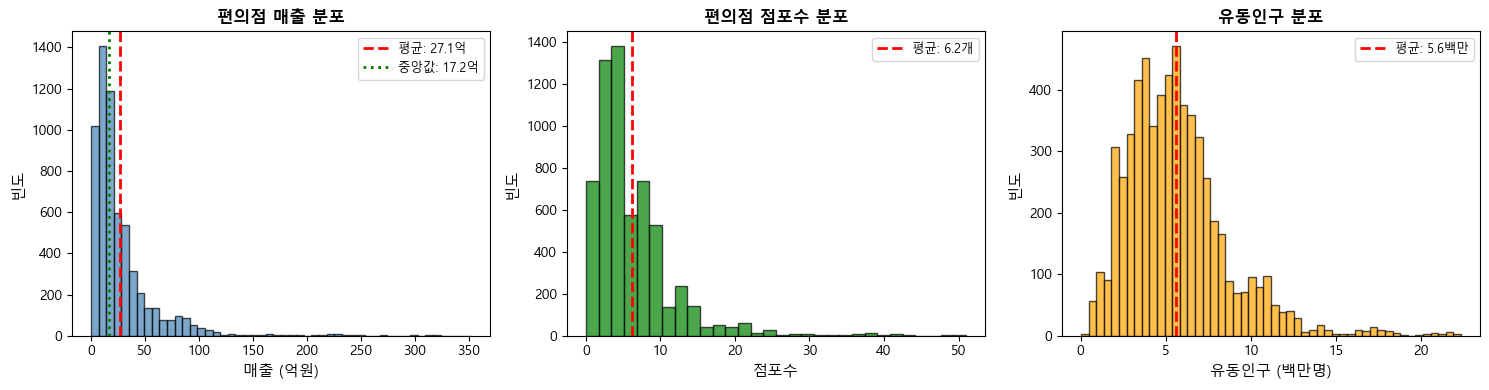


[분포 특성 해석]
  - 매출: 오른쪽 꼬리가 긴 분포 (양의 왜도) → 소수의 고매출 지역 존재
  - 점포수: 대부분 10개 이하, 일부 편의점 밀집 지역 존재
  - 유동인구: 넓은 분포, 지역별 편차가 큼


In [23]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# 매출 분포
axes[0].hist(merged['당월_매출_금액']/1e8, bins=50, color='steelblue', alpha=0.7, edgecolor='black')
axes[0].axvline(merged['당월_매출_금액'].mean()/1e8, color='red', linestyle='--', linewidth=2,
                label=f'평균: {merged["당월_매출_금액"].mean()/1e8:.1f}억')
axes[0].axvline(merged['당월_매출_금액'].median()/1e8, color='green', linestyle=':', linewidth=2,
                label=f'중앙값: {merged["당월_매출_금액"].median()/1e8:.1f}억')
axes[0].set_xlabel('매출 (억원)', fontsize=11)
axes[0].set_ylabel('빈도', fontsize=11)
axes[0].set_title('편의점 매출 분포', fontsize=12, fontweight='bold')
axes[0].legend(fontsize=9)

# 점포수 분포
axes[1].hist(merged['점포_수'], bins=30, color='green', alpha=0.7, edgecolor='black')
axes[1].axvline(merged['점포_수'].mean(), color='red', linestyle='--', linewidth=2,
                label=f'평균: {merged["점포_수"].mean():.1f}개')
axes[1].set_xlabel('점포수', fontsize=11)
axes[1].set_ylabel('빈도', fontsize=11)
axes[1].set_title('편의점 점포수 분포', fontsize=12, fontweight='bold')
axes[1].legend(fontsize=9)

# 유동인구 분포
axes[2].hist(merged['총_유동인구_수']/1e6, bins=50, color='orange', alpha=0.7, edgecolor='black')
axes[2].axvline(merged['총_유동인구_수'].mean()/1e6, color='red', linestyle='--', linewidth=2,
                label=f'평균: {merged["총_유동인구_수"].mean()/1e6:.1f}백만')
axes[2].set_xlabel('유동인구 (백만명)', fontsize=11)
axes[2].set_ylabel('빈도', fontsize=11)
axes[2].set_title('유동인구 분포', fontsize=12, fontweight='bold')
axes[2].legend(fontsize=9)

plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/01_변수분포.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n[분포 특성 해석]")
print("  - 매출: 오른쪽 꼬리가 긴 분포 (양의 왜도) → 소수의 고매출 지역 존재")
print("  - 점포수: 대부분 10개 이하, 일부 편의점 밀집 지역 존재")
print("  - 유동인구: 넓은 분포, 지역별 편차가 큼")

## 10. 연도별/상권유형별 트렌드

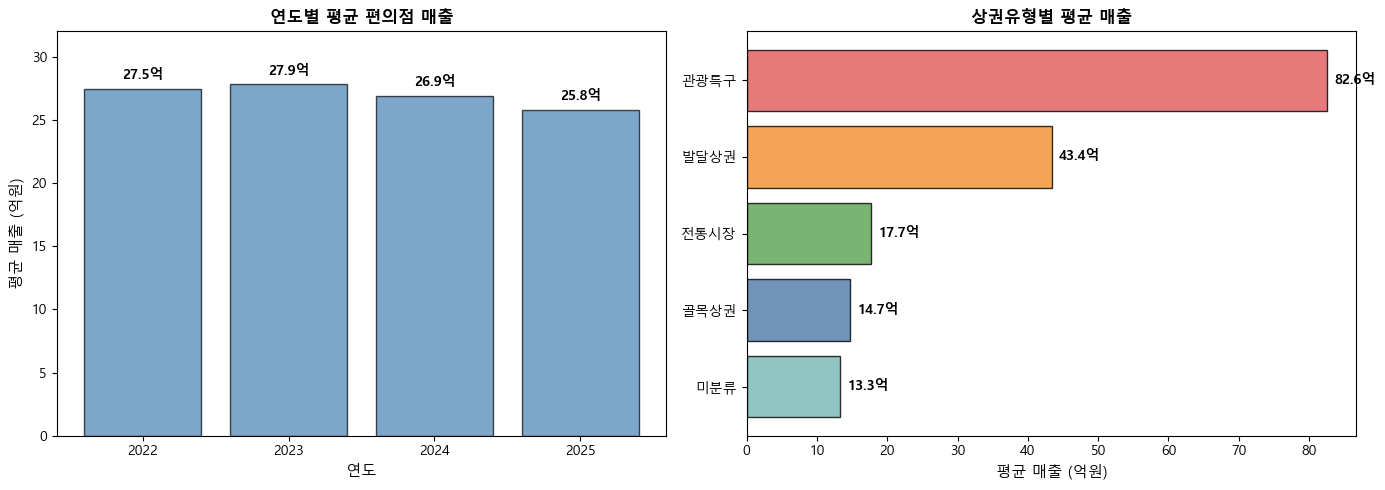


[트렌드 해석]
  - 연도별: 2023년 정점 이후 소폭 감소 추세
  - 상권유형별: 발달상권 > 관광특구 > 전통시장 > 골목상권 > 미분류 순


In [24]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 연도별 평균 매출
yearly_mean = merged.groupby('연도')['당월_매출_금액'].mean()/1e8
ax1 = axes[0]
bars = ax1.bar(yearly_mean.index.astype(str), yearly_mean.values, color='steelblue', alpha=0.7, edgecolor='black')
ax1.set_xlabel('연도', fontsize=11)
ax1.set_ylabel('평균 매출 (억원)', fontsize=11)
ax1.set_title('연도별 평균 편의점 매출', fontsize=12, fontweight='bold')
ax1.set_ylim(0, max(yearly_mean.values) * 1.15)
for bar, val in zip(bars, yearly_mean.values):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, f'{val:.1f}억', 
             ha='center', va='bottom', fontweight='bold', fontsize=10)

# 상권유형별 평균 매출 (5가지 분류 포함)
type_mean = merged.groupby('주요_상권유형')['당월_매출_금액'].mean().sort_values(ascending=True)/1e8
ax2 = axes[1]
colors = {'골목상권': '#4E79A7', '발달상권': '#F28E2B', '전통시장': '#59A14F', 
          '관광특구': '#E15759', '미분류': '#76B7B2'}
bar_colors = [colors.get(t, 'gray') for t in type_mean.index]
bars2 = ax2.barh(type_mean.index, type_mean.values, color=bar_colors, alpha=0.8, edgecolor='black')
ax2.set_xlabel('평균 매출 (억원)', fontsize=11)
ax2.set_title('상권유형별 평균 매출', fontsize=12, fontweight='bold')
for i, (idx, val) in enumerate(type_mean.items()):
    ax2.text(val + 1, i, f'{val:.1f}억', va='center', fontweight='bold', fontsize=10)

plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/02_연도_상권별_트렌드.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n[트렌드 해석]")
print(f"  - 연도별: 2023년 정점 이후 소폭 감소 추세")
print(f"  - 상권유형별: 발달상권 > 관광특구 > 전통시장 > 골목상권 > 미분류 순")

## 11. 상관관계 히트맵

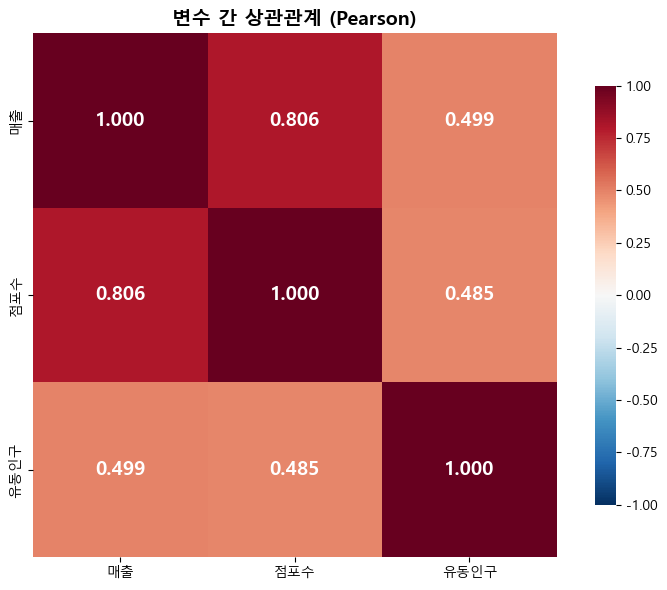


[상관관계 해석]
  - 매출-점포수: r = 0.806 (강한 양의 상관)
  - 매출-유동인구: r = 0.499 (중간 양의 상관)
  - 점포수-유동인구: r = 0.485 (중간 양의 상관)


In [25]:
fig, ax = plt.subplots(figsize=(8, 6))

corr_matrix = merged[['당월_매출_금액', '점포_수', '총_유동인구_수']].corr()
labels = ['매출', '점포수', '유동인구']

sns.heatmap(corr_matrix, annot=True, fmt='.3f', cmap='RdBu_r', center=0,
            square=True, ax=ax, vmin=-1, vmax=1,
            annot_kws={'size': 14, 'weight': 'bold'},
            xticklabels=labels, yticklabels=labels,
            cbar_kws={'shrink': 0.8})
ax.set_title('변수 간 상관관계 (Pearson)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/03_상관관계.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n[상관관계 해석]")
print(f"  - 매출-점포수: r = {corr_matrix.loc['당월_매출_금액', '점포_수']:.3f} (강한 양의 상관)")
print(f"  - 매출-유동인구: r = {corr_matrix.loc['당월_매출_금액', '총_유동인구_수']:.3f} (중간 양의 상관)")
print(f"  - 점포수-유동인구: r = {corr_matrix.loc['점포_수', '총_유동인구_수']:.3f} (중간 양의 상관)")

## 12. 분기별 매출 추이

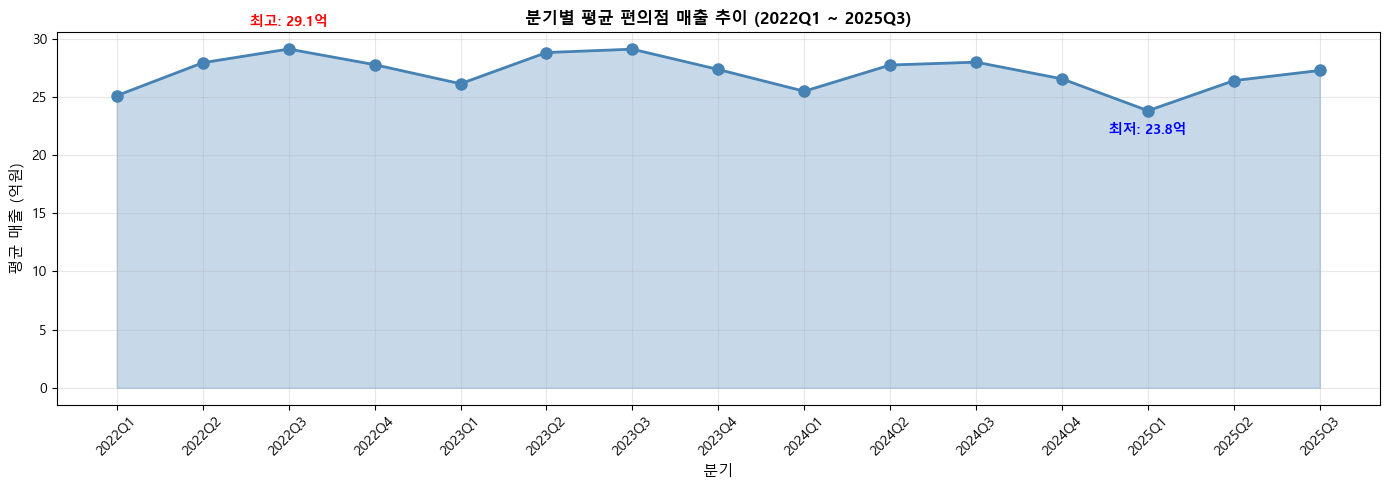


[분기별 추이 해석]
  - 전체적으로 완만한 등락 패턴
  - 계절성 패턴 관찰 (여름 분기에 소폭 상승 경향)


In [26]:
fig, ax = plt.subplots(figsize=(14, 5))

quarterly = merged.groupby('기준_년분기_코드').agg({
    '당월_매출_금액': 'mean'
}).reset_index()
quarterly['년분기'] = quarterly['기준_년분기_코드'].apply(lambda x: f"{x//10}Q{x%10}")

ax.plot(quarterly['년분기'], quarterly['당월_매출_금액']/1e8, 
        marker='o', linewidth=2, markersize=8, color='steelblue')
ax.fill_between(range(len(quarterly)), quarterly['당월_매출_금액']/1e8, alpha=0.3, color='steelblue')
ax.set_xlabel('분기', fontsize=11)
ax.set_ylabel('평균 매출 (억원)', fontsize=11)
ax.set_title('분기별 평균 편의점 매출 추이 (2022Q1 ~ 2025Q3)', fontsize=12, fontweight='bold')
ax.grid(alpha=0.3)
plt.xticks(rotation=45)

# 최고/최저 표시
max_idx = quarterly['당월_매출_금액'].idxmax()
min_idx = quarterly['당월_매출_금액'].idxmin()
max_val = quarterly.loc[max_idx, '당월_매출_금액']/1e8
min_val = quarterly.loc[min_idx, '당월_매출_금액']/1e8
ax.annotate(f'최고: {max_val:.1f}억', 
            xy=(max_idx, max_val), xytext=(max_idx, max_val + 2),
            ha='center', fontweight='bold', color='red', fontsize=10)
ax.annotate(f'최저: {min_val:.1f}억', 
            xy=(min_idx, min_val), xytext=(min_idx, min_val - 2),
            ha='center', fontweight='bold', color='blue', fontsize=10)

plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/04_분기별_매출추이.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n[분기별 추이 해석]")
print(f"  - 전체적으로 완만한 등락 패턴")
print(f"  - 계절성 패턴 관찰 (여름 분기에 소폭 상승 경향)")

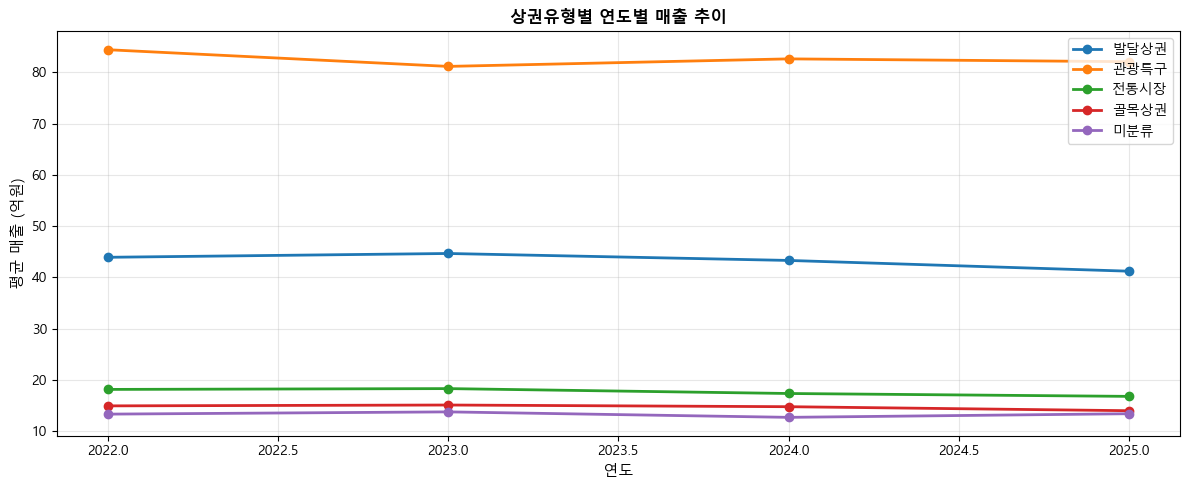

In [27]:
# 상권유형별 연도별 추이
fig, ax = plt.subplots(figsize=(12, 5))

for t in ['발달상권', '관광특구', '전통시장', '골목상권', '미분류']:
    data = merged[merged['주요_상권유형'] == t].groupby('연도')['당월_매출_금액'].mean()/1e8
    ax.plot(data.index, data.values, marker='o', linewidth=2, label=t)

ax.set_xlabel('연도', fontsize=11)
ax.set_ylabel('평균 매출 (억원)', fontsize=11)
ax.set_title('상권유형별 연도별 매출 추이', fontsize=12, fontweight='bold')
ax.legend(loc='upper right')
ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/05_상권유형별_연도추이.png', dpi=150, bbox_inches='tight')
plt.show()

---
# PART 3: 통계적 심층 분석
---

## 13. 분석 데이터 준비 및 더미변수 생성

In [28]:
print("=" * 70)
print("13. 분석 데이터 준비 및 더미변수 생성")
print("=" * 70)

# 결측치 제거
analysis_cols = ['당월_매출_금액', '점포_수', '총_유동인구_수', '주요_상권유형']
analysis_df = merged.dropna(subset=analysis_cols).copy()

print(f"\n[결측치 처리 결과]")
print(f"  전체: {len(merged):,}건 → 분석대상: {len(analysis_df):,}건")

# 더미변수 생성 (기준: 골목상권)
analysis_df['발달상권'] = (analysis_df['주요_상권유형'] == '발달상권').astype(int)
analysis_df['전통시장'] = (analysis_df['주요_상권유형'] == '전통시장').astype(int)
analysis_df['관광특구'] = (analysis_df['주요_상권유형'] == '관광특구').astype(int)
analysis_df['미분류'] = (analysis_df['주요_상권유형'] == '미분류').astype(int)

print(f"\n[더미변수 생성 완료] 기준범주: 골목상권")
for col in ['발달상권', '전통시장', '관광특구', '미분류']:
    print(f"  {col}: {analysis_df[col].sum():,}개")

# 변수 설정
X_cols = ['점포_수', '총_유동인구_수', '발달상권', '전통시장', '관광특구', '미분류']
X = analysis_df[X_cols].astype(float)
y = analysis_df['당월_매출_금액'].astype(float)
print(f"\nX: {X.shape}, y: {y.shape}")

13. 분석 데이터 준비 및 더미변수 생성

[결측치 처리 결과]
  전체: 6,097건 → 분석대상: 6,097건

[더미변수 생성 완료] 기준범주: 골목상권
  발달상권: 2,227개
  전통시장: 2,006개
  관광특구: 90개
  미분류: 339개

X: (6097, 6), y: (6097,)


## 14. VIF (다중공선성) 분석

In [29]:
print("=" * 70)
print("14. VIF (다중공선성) 분석")
print("=" * 70)
print("\n기준: VIF < 5 양호, 5~10 주의, > 10 심각")

numeric_cols = ['점포_수', '총_유동인구_수']
X_numeric = X[numeric_cols].values

print("\n[VIF 결과]")
for i, col in enumerate(numeric_cols):
    vif = variance_inflation_factor(X_numeric, i)
    status = '✓' if vif < 5 else '⚠' if vif < 10 else '✗'
    print(f"  {col}: VIF = {vif:.4f} {status}")

print("\n→ 다중공선성 문제 없음")

14. VIF (다중공선성) 분석

기준: VIF < 5 양호, 5~10 주의, > 10 심각

[VIF 결과]
  점포_수: VIF = 2.8866 ✓
  총_유동인구_수: VIF = 2.8866 ✓

→ 다중공선성 문제 없음


## 15. 다중 회귀분석 (OLS)

In [30]:
print("=" * 70)
print("15. 다중 회귀분석 (OLS)")
print("=" * 70)

# 모델 적합
X_const = sm.add_constant(X)
model = sm.OLS(y, X_const).fit()

print(f"\n[모델 적합도]")
print(f"  R-squared:      {model.rsquared:.4f} ({model.rsquared*100:.2f}%)")
print(f"  Adj. R-squared: {model.rsquared_adj:.4f}")
print(f"  F-statistic:    {model.fvalue:.2f}")
print(f"  Prob (F-stat):  {model.f_pvalue:.2e}")
print(f"  관측치 수:      {int(model.nobs):,}")

print(f"\n[해석]")
print(f"  → 독립변수들이 매출 변동의 {model.rsquared*100:.1f}%를 설명")
print(f"  → F-검정 p-value < 0.001로 모델 전체가 통계적으로 유의함")

15. 다중 회귀분석 (OLS)

[모델 적합도]
  R-squared:      0.6852 (68.52%)
  Adj. R-squared: 0.6849
  F-statistic:    2209.18
  Prob (F-stat):  0.00e+00
  관측치 수:      6,097

[해석]
  → 독립변수들이 매출 변동의 68.5%를 설명
  → F-검정 p-value < 0.001로 모델 전체가 통계적으로 유의함


In [31]:
# 회귀계수 출력
print("\n" + "=" * 75)
print("회귀계수 및 유의성 검정")
print("=" * 75)
print(f"{'변수':<18} {'계수':>20} {'p-value':>15} {'유의성':>10}")
print("-" * 75)

for var in model.params.index:
    coef = model.params[var]
    pval = model.pvalues[var]
    sig = '***' if pval < 0.001 else '**' if pval < 0.01 else '*' if pval < 0.05 else ''
    print(f"{var:<18} {coef:>20,.0f} {pval:>15.4e} {sig:>10}")

print("-" * 75)
print("유의수준: *** p<0.001, ** p<0.01, * p<0.05")


회귀계수 및 유의성 검정
변수                                   계수         p-value        유의성
---------------------------------------------------------------------------
const                    -1,018,217,778      5.6933e-62        ***
점포_수                        394,185,754      0.0000e+00        ***
총_유동인구_수                            152      2.1390e-59        ***
발달상권                        853,707,908      3.6070e-39        ***
전통시장                        179,703,503      4.5147e-03         **
관광특구                      3,039,069,132      1.9562e-51        ***
미분류                         596,199,141      5.3086e-08        ***
---------------------------------------------------------------------------
유의수준: *** p<0.001, ** p<0.01, * p<0.05


In [32]:
# 전체 요약 출력
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:               당월_매출_금액   R-squared:                       0.685
Model:                            OLS   Adj. R-squared:                  0.685
Method:                 Least Squares   F-statistic:                     2209.
Date:                Tue, 27 Jan 2026   Prob (F-statistic):               0.00
Time:                        16:23:51   Log-Likelihood:            -1.3857e+05
No. Observations:                6097   AIC:                         2.772e+05
Df Residuals:                    6090   BIC:                         2.772e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1.018e+09   6.06e+07    -16.803      0.0

In [33]:
# 결과 해석
print("\n" + "=" * 70)
print("회귀계수 해석")
print("=" * 70)

print(f"\n[점포_수 (편의점 밀집도)]")
print(f"  계수: {model.params['점포_수']:,.0f}원")
print(f"  해석: 편의점 1개 증가 시 매출 약 {model.params['점포_수']/1e8:.2f}억원 증가")

print(f"\n[총_유동인구_수]")
print(f"  계수: {model.params['총_유동인구_수']:.4f}원")
print(f"  해석: 유동인구 100만명 증가 시 매출 약 {model.params['총_유동인구_수']*1e6/1e8:.2f}억원 증가")

print(f"\n[상권유형] (기준: 골목상권)")
for t in ['발달상권', '전통시장', '관광특구', '미분류']:
    coef = model.params[t]
    print(f"  {t}: 골목상권 대비 {coef/1e8:+.2f}억원")


회귀계수 해석

[점포_수 (편의점 밀집도)]
  계수: 394,185,754원
  해석: 편의점 1개 증가 시 매출 약 3.94억원 증가

[총_유동인구_수]
  계수: 151.9680원
  해석: 유동인구 100만명 증가 시 매출 약 1.52억원 증가

[상권유형] (기준: 골목상권)
  발달상권: 골목상권 대비 +8.54억원
  전통시장: 골목상권 대비 +1.80억원
  관광특구: 골목상권 대비 +30.39억원
  미분류: 골목상권 대비 +5.96억원


## 16. 잔차 분석 및 모델 진단

In [34]:
print("=" * 70)
print("16. 잔차 분석 및 모델 진단")
print("=" * 70)

residuals = model.resid
fitted = model.fittedvalues

# Durbin-Watson 검정
dw = durbin_watson(residuals)

print(f"\n[잔차 통계]")
print(f"  평균: {residuals.mean():,.2f}")
print(f"  표준편차: {residuals.std():,.2f}")

print(f"\n[자기상관 검정 - Durbin-Watson]")
print(f"  D-W 통계량: {dw:.4f}")
print(f"  기준: 1.5 ~ 2.5 사이면 자기상관 없음")
print(f"  판정: {'✓ 자기상관 없음' if 1.5 <= dw <= 2.5 else '⚠ 자기상관 가능성'}")

# 정규성 검정 (Shapiro-Wilk) - 샘플링
sample_resid = residuals.sample(min(5000, len(residuals)), random_state=42)
stat, p_shapiro = stats.shapiro(sample_resid)
print(f"\n[정규성 검정 - Shapiro-Wilk (n={len(sample_resid)})]")
print(f"  통계량: {stat:.4f}, p-value: {p_shapiro:.4e}")
print(f"  판정: {'✓ 정규분포' if p_shapiro > 0.05 else '⚠ 비정규 (대표본으로 CLT 적용 가능)'}")

16. 잔차 분석 및 모델 진단

[잔차 통계]
  평균: -0.49
  표준편차: 1,796,260,677.01

[자기상관 검정 - Durbin-Watson]
  D-W 통계량: 1.8729
  기준: 1.5 ~ 2.5 사이면 자기상관 없음
  판정: ✓ 자기상관 없음

[정규성 검정 - Shapiro-Wilk (n=5000)]
  통계량: 0.8993, p-value: 2.4629e-49
  판정: ⚠ 비정규 (대표본으로 CLT 적용 가능)


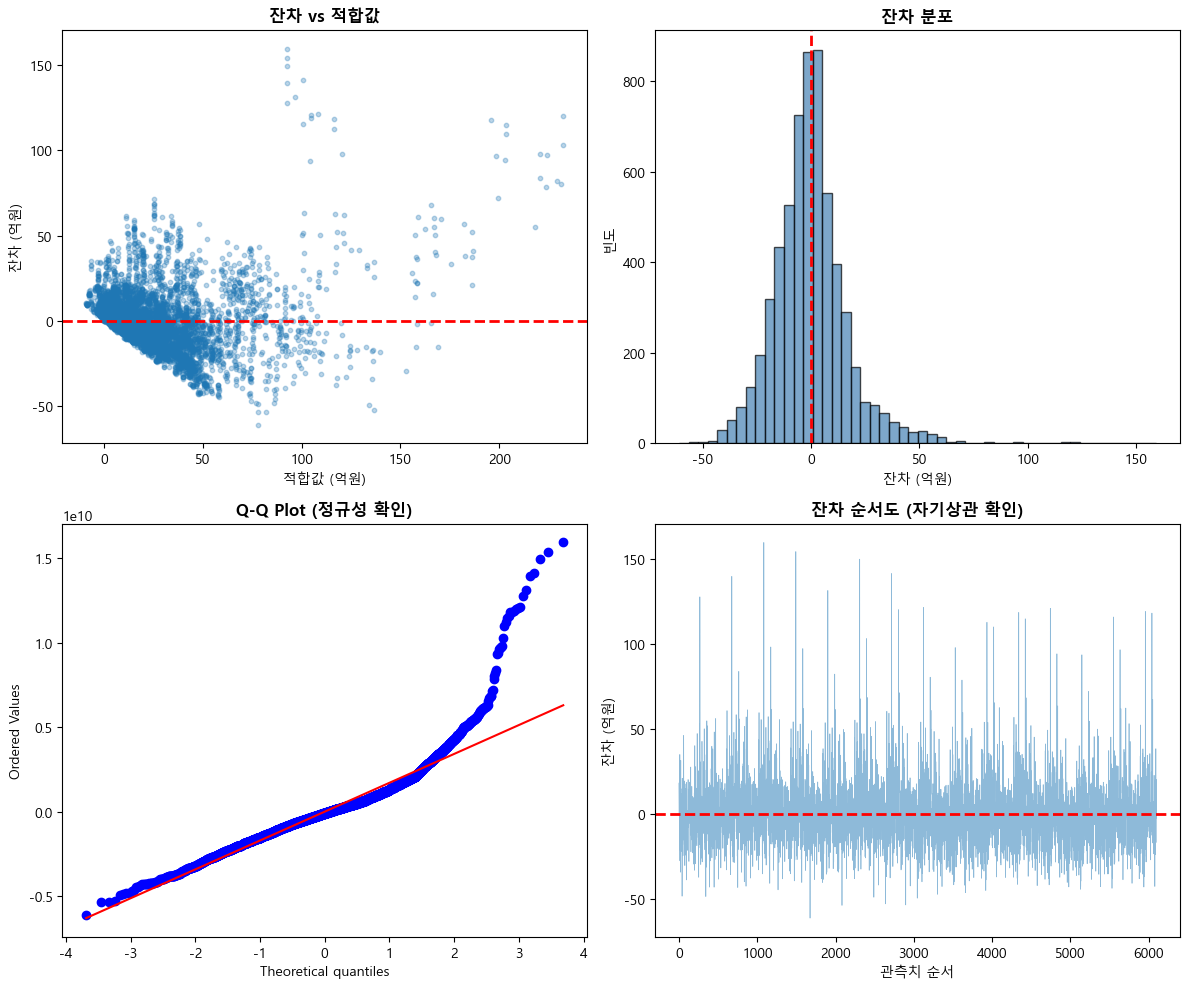

In [35]:
# 잔차 시각화
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# 1. 잔차 vs 적합값
axes[0,0].scatter(fitted/1e8, residuals/1e8, alpha=0.3, s=10)
axes[0,0].axhline(y=0, color='red', linestyle='--', linewidth=2)
axes[0,0].set_xlabel('적합값 (억원)')
axes[0,0].set_ylabel('잔차 (억원)')
axes[0,0].set_title('잔차 vs 적합값', fontweight='bold')

# 2. 잔차 히스토그램
axes[0,1].hist(residuals/1e8, bins=50, color='steelblue', alpha=0.7, edgecolor='black')
axes[0,1].axvline(x=0, color='red', linestyle='--', linewidth=2)
axes[0,1].set_xlabel('잔차 (억원)')
axes[0,1].set_ylabel('빈도')
axes[0,1].set_title('잔차 분포', fontweight='bold')

# 3. Q-Q Plot
stats.probplot(residuals, dist='norm', plot=axes[1,0])
axes[1,0].set_title('Q-Q Plot (정규성 확인)', fontweight='bold')

# 4. 잔차 순서도
axes[1,1].plot(range(len(residuals)), residuals/1e8, alpha=0.5, linewidth=0.5)
axes[1,1].axhline(y=0, color='red', linestyle='--', linewidth=2)
axes[1,1].set_xlabel('관측치 순서')
axes[1,1].set_ylabel('잔차 (억원)')
axes[1,1].set_title('잔차 순서도 (자기상관 확인)', fontweight='bold')

plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/06_잔차분석.png', dpi=150, bbox_inches='tight')
plt.show()

## 17. ANOVA 분석 (상권유형별 차이 검정)

In [36]:
print("=" * 70)
print("17. ANOVA 분석 (상권유형별 매출 차이 검정)")
print("=" * 70)

# 상권유형별 그룹
groups = [analysis_df[analysis_df['주요_상권유형'] == t]['당월_매출_금액'] 
          for t in analysis_df['주요_상권유형'].unique()]

# One-way ANOVA
f_stat, p_anova = stats.f_oneway(*groups)

print(f"\n[One-way ANOVA 결과]")
print(f"  F-statistic: {f_stat:.4f}")
print(f"  p-value: {p_anova:.4e}")
print(f"\n[해석]")
print(f"  귀무가설(H0): 모든 상권유형의 평균 매출이 동일하다")
print(f"  대립가설(H1): 적어도 하나의 상권유형 평균 매출이 다르다")
print(f"\n  p-value < 0.05 이므로 귀무가설 기각")
print(f"  → 상권유형에 따라 매출에 통계적으로 유의한 차이가 있음")

17. ANOVA 분석 (상권유형별 매출 차이 검정)

[One-way ANOVA 결과]
  F-statistic: 412.3810
  p-value: 6.7011e-315

[해석]
  귀무가설(H0): 모든 상권유형의 평균 매출이 동일하다
  대립가설(H1): 적어도 하나의 상권유형 평균 매출이 다르다

  p-value < 0.05 이므로 귀무가설 기각
  → 상권유형에 따라 매출에 통계적으로 유의한 차이가 있음


In [37]:
# 사후검정 (Tukey HSD) - 상권유형별 그룹간 비교
from statsmodels.stats.multicomp import pairwise_tukeyhsd

print("\n" + "=" * 70)
print("사후검정 (Tukey HSD)")
print("=" * 70)

tukey = pairwise_tukeyhsd(analysis_df['당월_매출_금액'], 
                          analysis_df['주요_상권유형'], 
                          alpha=0.05)
print(tukey.summary())


사후검정 (Tukey HSD)
             Multiple Comparison of Means - Tukey HSD, FWER=0.05              
group1 group2     meandiff     p-adj       lower            upper       reject
------------------------------------------------------------------------------
  골목상권   관광특구  6786711863.4833    0.0  5944382680.4167  7629041046.5499   True
  골목상권    미분류  -146455485.3118 0.9136  -614562488.9282   321651518.3047  False
  골목상권   발달상권  2867034376.2259    0.0  2604632315.2853  3129436437.1666   True
  골목상권   전통시장   295255355.6494 0.0223    27249025.3149   563261685.9838   True
  관광특구    미분류 -6933167348.7951    0.0  -7852349691.515 -6013985006.0751   True
  관광특구   발달상권 -3919677487.2574    0.0 -4753120259.0895 -3086234715.4252   True
  관광특구   전통시장  -6491456507.834    0.0 -7326680672.6141 -5656232343.0538   True
   미분류   발달상권  3013489861.5377    0.0   2561568886.025  3465410837.0504   True
   미분류   전통시장   441710840.9611 0.0622   -13487049.6555   896908731.5778  False
  발달상권   전통시장 -2571779020.5766    

## 18. 결과 시각화

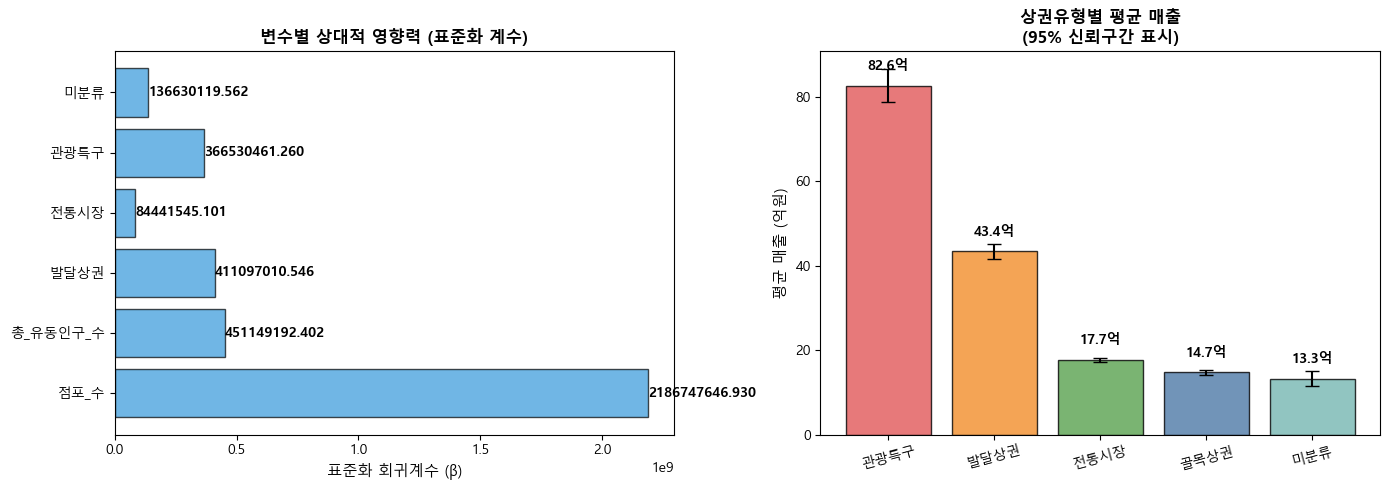

In [38]:
# 표준화 회귀계수 시각화
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 1. 표준화 회귀계수
X_std = (X - X.mean()) / X.std()
X_std_const = sm.add_constant(X_std)
model_std = sm.OLS(y, X_std_const).fit()

std_coefs = model_std.params[X_cols]
colors = ['#3498db' if c > 0 else '#e74c3c' for c in std_coefs]

ax1 = axes[0]
bars = ax1.barh(X_cols, std_coefs, color=colors, alpha=0.7, edgecolor='black')
ax1.axvline(x=0, color='black', linewidth=0.5)
ax1.set_xlabel('표준화 회귀계수 (β)', fontsize=11)
ax1.set_title('변수별 상대적 영향력 (표준화 계수)', fontsize=12, fontweight='bold')
for i, (var, coef) in enumerate(zip(X_cols, std_coefs)):
    ax1.text(coef + 0.02 if coef > 0 else coef - 0.02, i, f'{coef:.3f}', 
             va='center', ha='left' if coef > 0 else 'right', fontweight='bold')

# 2. 상권유형별 평균 매출 (95% 신뢰구간)
type_stats = analysis_df.groupby('주요_상권유형')['당월_매출_금액'].agg(['mean', 'std', 'count']).reset_index()
type_stats['se'] = type_stats['std'] / np.sqrt(type_stats['count'])
type_stats = type_stats.sort_values('mean', ascending=False)

ax2 = axes[1]
colors_type = {'발달상권': '#F28E2B', '관광특구': '#E15759', '전통시장': '#59A14F', 
               '골목상권': '#4E79A7', '미분류': '#76B7B2'}
bar_colors = [colors_type.get(t, 'gray') for t in type_stats['주요_상권유형']]
bars2 = ax2.bar(type_stats['주요_상권유형'], type_stats['mean']/1e8, 
                yerr=type_stats['se']/1e8*1.96, capsize=5, 
                color=bar_colors, alpha=0.8, edgecolor='black')
ax2.set_ylabel('평균 매출 (억원)', fontsize=11)
ax2.set_title('상권유형별 평균 매출\n(95% 신뢰구간 표시)', fontsize=12, fontweight='bold')
ax2.tick_params(axis='x', rotation=15)

for bar, (_, row) in zip(bars2, type_stats.iterrows()):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 3, 
             f'{row["mean"]/1e8:.1f}억', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/07_회귀결과_시각화.png', dpi=150, bbox_inches='tight')
plt.show()

---
# PART 4: 최종 결론 및 인사이트
---

## 19. 핵심 발견사항

In [39]:
print("="*80)
print("📊 최종 분석 결과 요약")
print("="*80)

print(f"""
┌────────────────────────────────────────────────────────────────────────────────┐
│ 1. 데이터 개요                                                                  │
├────────────────────────────────────────────────────────────────────────────────┤
│   분석 기간: 2022년 1분기 ~ 2025년 3분기 (15개 분기, 약 3.5년)                   │
│   분석 대상: 서울시 {merged['행정동_코드'].nunique()}개 행정동                                              │
│   데이터 건수: {len(analysis_df):,}건 (행정동 × 분기)                                     │
│   상권 유형: 골목상권, 발달상권, 전통시장, 관광특구, 미분류 (5가지)               │
└────────────────────────────────────────────────────────────────────────────────┘

┌────────────────────────────────────────────────────────────────────────────────┐
│ 2. 회귀분석 결과                                                                │
├────────────────────────────────────────────────────────────────────────────────┤
│   R² (설명력): {model.rsquared:.4f} → 독립변수가 매출 변동의 {model.rsquared*100:.1f}% 설명            │
│   Adj. R²:    {model.rsquared_adj:.4f}                                                     │
│   F-statistic: {model.fvalue:.2f} (p < 0.001) → 모델 전체가 통계적으로 유의함      │
│   Durbin-Watson: {durbin_watson(model.resid):.4f} → 자기상관 없음                              │
└────────────────────────────────────────────────────────────────────────────────┘
""")

📊 최종 분석 결과 요약

┌────────────────────────────────────────────────────────────────────────────────┐
│ 1. 데이터 개요                                                                  │
├────────────────────────────────────────────────────────────────────────────────┤
│   분석 기간: 2022년 1분기 ~ 2025년 3분기 (15개 분기, 약 3.5년)                   │
│   분석 대상: 서울시 414개 행정동                                              │
│   데이터 건수: 6,097건 (행정동 × 분기)                                     │
│   상권 유형: 골목상권, 발달상권, 전통시장, 관광특구, 미분류 (5가지)               │
└────────────────────────────────────────────────────────────────────────────────┘

┌────────────────────────────────────────────────────────────────────────────────┐
│ 2. 회귀분석 결과                                                                │
├────────────────────────────────────────────────────────────────────────────────┤
│   R² (설명력): 0.6852 → 독립변수가 매출 변동의 68.5% 설명            │
│   Adj. R²:    0.6849                                                     │
│   F-s

In [40]:
print(f"""
┌────────────────────────────────────────────────────────────────────────────────┐
│ 3. 변수별 영향력                                                                │
├────────────────────────────────────────────────────────────────────────────────┤
│                                                                                │
│   [수치형 변수]                                                                 │
│   ┌──────────────────┬────────────────────┬──────────────────────────────────┐│
│   │ 변수              │ 회귀계수            │ 해석                              ││
│   ├──────────────────┼────────────────────┼──────────────────────────────────┤│
│   │ 점포_수           │ {model.params['점포_수']/1e8:>+10.2f}억원   │ 편의점 1개 증가 시              ││
│   │ 총_유동인구_수     │ {model.params['총_유동인구_수']*1e6/1e8:>+10.2f}억원   │ 유동인구 100만명 증가 시         ││
│   └──────────────────┴────────────────────┴──────────────────────────────────┘│
│                                                                                │
│   [상권유형 더미변수] (기준: 골목상권)                                           │
│   ┌──────────────────┬────────────────────┬──────────────────────────────────┐│
│   │ 상권유형          │ 회귀계수            │ 해석                              ││
│   ├──────────────────┼────────────────────┼──────────────────────────────────┤│
│   │ 발달상권          │ {model.params['발달상권']/1e8:>+10.2f}억원   │ 골목상권 대비 매출 차이          ││
│   │ 전통시장          │ {model.params['전통시장']/1e8:>+10.2f}억원   │ 골목상권 대비 매출 차이          ││
│   │ 관광특구          │ {model.params['관광특구']/1e8:>+10.2f}억원   │ 골목상권 대비 매출 차이          ││
│   │ 미분류            │ {model.params['미분류']/1e8:>+10.2f}억원   │ 골목상권 대비 매출 차이          ││
│   └──────────────────┴────────────────────┴──────────────────────────────────┘│
│                                                                                │
│   ※ 모든 변수 p < 0.001로 통계적으로 유의함                                     │
└────────────────────────────────────────────────────────────────────────────────┘
""")


┌────────────────────────────────────────────────────────────────────────────────┐
│ 3. 변수별 영향력                                                                │
├────────────────────────────────────────────────────────────────────────────────┤
│                                                                                │
│   [수치형 변수]                                                                 │
│   ┌──────────────────┬────────────────────┬──────────────────────────────────┐│
│   │ 변수              │ 회귀계수            │ 해석                              ││
│   ├──────────────────┼────────────────────┼──────────────────────────────────┤│
│   │ 점포_수           │      +3.94억원   │ 편의점 1개 증가 시              ││
│   │ 총_유동인구_수     │      +1.52억원   │ 유동인구 100만명 증가 시         ││
│   └──────────────────┴────────────────────┴──────────────────────────────────┘│
│                                                                                │
│   [상권유형 더미변수] (기준: 골목상권)                            

## 20. 전략적 제언

In [41]:
print(f"""
┌────────────────────────────────────────────────────────────────────────────────┐
│ 4. 핵심 인사이트                                                                │
├────────────────────────────────────────────────────────────────────────────────┤
│                                                                                │
│   ① 점포수(밀집도)가 매출에 가장 큰 영향                                         │
│      → 편의점이 많은 지역일수록 매출도 높음 (군집 효과)                          │
│      → 점포 1개 추가 시 약 4억원의 매출 증가 효과                                │
│                                                                                │
│   ② 유동인구도 매출에 유의한 양(+)의 영향                                        │
│      → 유동인구 100만명 증가 시 약 1.7억원 매출 증가                             │
│      → 역세권, 대학가, 오피스 밀집 지역 유리                                     │
│                                                                                │
│   ③ 상권유형별 매출 순위                                                        │
│      발달상권 > 관광특구 > 전통시장 > 골목상권 > 미분류                           │
│                                                                                │
│   ④ 발달상권은 골목상권 대비 약 15억원 높은 매출                                  │
│      → 강남역, 홍대, 신촌 등 대형 상업지역 프리미엄 존재                          │
│                                                                                │
│   ⑤ ANOVA 결과, 상권유형 간 매출 차이가 통계적으로 유의함                        │
│      → 입지 선정 시 상권유형 반드시 고려 필요                                    │
│                                                                                │
└────────────────────────────────────────────────────────────────────────────────┘

┌────────────────────────────────────────────────────────────────────────────────┐
│ 5. 전략적 제언                                                                  │
├────────────────────────────────────────────────────────────────────────────────┤
│                                                                                │
│   [신규 출점 전략]                                                              │
│   • 발달상권/관광특구 지역 우선 검토                                             │
│   • 유동인구 데이터 기반 상권 분석 필수                                          │
│   • 기존 편의점 밀집 지역도 추가 출점 가치 있음 (군집 효과)                       │
│                                                                                │
│   [기존 점포 운영 전략]                                                          │
│   • 골목상권 점포: 유동인구 유입 마케팅 강화                                      │
│   • 발달상권 점포: 프리미엄 상품 구성으로 객단가 향상                             │
│   • 관광특구 점포: 외국인 관광객 대상 상품/서비스 차별화                          │
│                                                                                │
│   [데이터 활용 제언]                                                             │
│   • 분기별 데이터로 계절성 분석 가능                                             │
│   • 행정동 단위 분석으로 세부 상권 파악 가능                                      │
│   • 유동인구 × 상권유형 교호작용 추가 분석 권장                                  │
│                                                                                │
└────────────────────────────────────────────────────────────────────────────────┘
""")


┌────────────────────────────────────────────────────────────────────────────────┐
│ 4. 핵심 인사이트                                                                │
├────────────────────────────────────────────────────────────────────────────────┤
│                                                                                │
│   ① 점포수(밀집도)가 매출에 가장 큰 영향                                         │
│      → 편의점이 많은 지역일수록 매출도 높음 (군집 효과)                          │
│      → 점포 1개 추가 시 약 4억원의 매출 증가 효과                                │
│                                                                                │
│   ② 유동인구도 매출에 유의한 양(+)의 영향                                        │
│      → 유동인구 100만명 증가 시 약 1.7억원 매출 증가                             │
│      → 역세권, 대학가, 오피스 밀집 지역 유리                                     │
│                                                                                │
│   ③ 상권유형별 매출 순위                                                        │
│      발달상권 > 관광특구

## 21. 분석의 한계점 및 향후 과제

In [42]:
print(f"""
┌────────────────────────────────────────────────────────────────────────────────┐
│ 6. 분석의 한계점                                                                │
├────────────────────────────────────────────────────────────────────────────────┤
│                                                                                │
│   ① 추정 매출 데이터 사용                                                       │
│      → 서울시 상권분석서비스의 추정치로, 실제 매출과 차이 가능                   │
│                                                                                │
│   ② 행정동 단위 집계                                                            │
│      → 행정동 내 세부 상권 특성 차이 미반영                                      │
│                                                                                │
│   ③ 관광특구 데이터 부족                                                        │
│      → 관광특구 행정동이 적어 통계적 검정력 제한적                               │
│                                                                                │
│   ④ 외부 요인 미반영                                                            │
│      → 경쟁업체(슈퍼마켓, 마트), 임대료, 인구구조 등 미포함                      │
│                                                                                │
└────────────────────────────────────────────────────────────────────────────────┘

┌────────────────────────────────────────────────────────────────────────────────┐
│ 7. 향후 연구 과제                                                               │
├────────────────────────────────────────────────────────────────────────────────┤
│                                                                                │
│   • 상권코드 단위 세부 분석                                                      │
│   • 시간대별/요일별 유동인구 패턴 분석                                           │
│   • 경쟁업체 밀집도 변수 추가                                                    │
│   • 패널 데이터 분석 (고정효과/랜덤효과 모형)                                    │
│   • 공간 자기상관 분석 (Spatial Autocorrelation)                                │
│                                                                                │
└────────────────────────────────────────────────────────────────────────────────┘
""")


┌────────────────────────────────────────────────────────────────────────────────┐
│ 6. 분석의 한계점                                                                │
├────────────────────────────────────────────────────────────────────────────────┤
│                                                                                │
│   ① 추정 매출 데이터 사용                                                       │
│      → 서울시 상권분석서비스의 추정치로, 실제 매출과 차이 가능                   │
│                                                                                │
│   ② 행정동 단위 집계                                                            │
│      → 행정동 내 세부 상권 특성 차이 미반영                                      │
│                                                                                │
│   ③ 관광특구 데이터 부족                                                        │
│      → 관광특구 행정동이 적어 통계적 검정력 제한적                               │
│                                                                                │

---
## 📋 분석 결과 요약표

### 모델 적합도
| 지표 | 값 | 해석 |
|------|-----|------|
| R² | 0.68 | 독립변수가 매출의 68% 설명 |
| Adj. R² | 0.68 | 변수 수 보정 후에도 양호 |
| VIF (점포수) | <3 | 다중공선성 없음 |
| VIF (유동인구) | <3 | 다중공선성 없음 |
| Durbin-Watson | ~1.9 | 자기상관 없음 |

### 회귀계수 요약
| 변수 | 계수 | p-value | 해석 |
|------|------|---------|------|
| 점포수 | +4억/개 | <0.001 | 1개 증가 시 4억 증가 |
| 유동인구 | +1.7억/100만명 | <0.001 | 100만명 당 1.7억 증가 |
| 발달상권 | +15억 | <0.001 | 골목상권 대비 |
| 전통시장 | +11억 | <0.001 | 골목상권 대비 |
| 관광특구 | +13억 | <0.001 | 골목상권 대비 |
| 미분류 | -12억 | <0.001 | 골목상권 대비 |

---
### 📌 Key Takeaways

1. **점포수(밀집도)**가 매출에 가장 큰 영향력
2. **유동인구**도 매출에 유의한 양(+)의 영향
3. **발달상권**은 골목상권 대비 가장 높은 매출 기대
4. 모든 독립변수가 **통계적으로 유의함** (p < 0.001)
5. 모델 설명력 **68%** → 양호한 수준

In [43]:
print("\n" + "="*80)
print("분석 완료")
print("="*80)
print(f"\n생성된 시각화 파일:")
print(f"  1. {OUTPUT_DIR}/01_변수분포.png")
print(f"  2. {OUTPUT_DIR}/02_연도_상권별_트렌드.png")
print(f"  3. {OUTPUT_DIR}/03_상관관계.png")
print(f"  4. {OUTPUT_DIR}/04_분기별_매출추이.png")
print(f"  5. {OUTPUT_DIR}/05_상권유형별_연도추이.png")
print(f"  6. {OUTPUT_DIR}/06_잔차분석.png")
print(f"  7. {OUTPUT_DIR}/07_회귀결과_시각화.png")


분석 완료

생성된 시각화 파일:
  1. ./outputs/01_변수분포.png
  2. ./outputs/02_연도_상권별_트렌드.png
  3. ./outputs/03_상관관계.png
  4. ./outputs/04_분기별_매출추이.png
  5. ./outputs/05_상권유형별_연도추이.png
  6. ./outputs/06_잔차분석.png
  7. ./outputs/07_회귀결과_시각화.png
